In [3]:
!pip install tensorflow opencv-python matplotlib

In [4]:
import tensorflow as tf

In [5]:
msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!


In [6]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
len(gpus)

0

In [10]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [11]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [17]:
POS_PATH = r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\data\positive'
NEG_PATH = r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\data\negative'
ANC_PATH = r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\data\anchor'

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())




b'C:\\Users\\suhan\\OneDrive\\Desktop\\deep_fake\\project\\data\\anchor\\9bd92fde-b08b-11ee-a5c4-f8a5c86ba23b.jpg'


In [19]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img
img = preprocess('C:\\Users\\suhan\\OneDrive\\Desktop\\deep_fake\\project\\data\\anchor\\6a3d6f38-b08b-11ee-9799-f8a5c86ba23b.jpg')
img.numpy().max() 

1.0

In [20]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple


(b'C:\\Users\\suhan\\OneDrive\\Desktop\\deep_fake\\project\\data\\anchor\\a07f6466-b08b-11ee-aacf-f8a5c86ba23b.jpg',
 b'C:\\Users\\suhan\\OneDrive\\Desktop\\deep_fake\\project\\data\\positive\\b0f50959-b079-11ee-bc3a-f8a5c86ba23b.jpg',
 1.0)

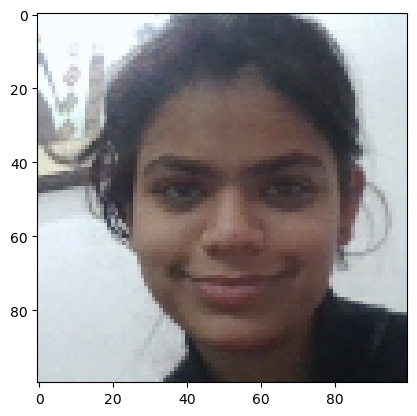

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [22]:

res[2]

1.0

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [25]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [26]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [27]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [28]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [29]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [32]:

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
l1 = L1Dist()


In [33]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [34]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [35]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [36]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [37]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [39]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

In [40]:
tf.losses.BinaryCrossentropy??

In [41]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [42]:
from tensorflow.keras.metrics import Precision, Recall

In [43]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [44]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 41s 1s/step
0.52972364 0.56796116 1.0

 Epoch 2/50
27/27 [==============================] - 51s 2s/step
0.09735083 0.97209305 1.0

 Epoch 3/50
27/27 [==============================] - 64s 2s/step
0.06309399 0.9859155 1.0

 Epoch 4/50
27/27 [==============================] - 65s 2s/step
0.21366286 0.99065423 1.0

 Epoch 5/50
27/27 [==============================] - 52s 2s/step
0.017006088 0.99545455 1.0

 Epoch 6/50
1/1 [==============================] - 0s 437ms/step


27/27 [==============================] - 53s 2s/step
0.014871205 0.9861111 1.0

 Epoch 7/50
27/27 [==============================] - 49s 2s/step
0.029677466 0.9852217 1.0

 Epoch 8/50
27/27 [==============================] - 47s 2s/step
0.018803956 0.9953271 1.0

 Epoch 9/50
27/27 [==============================] - 49s 2s/step
0.004365357 0.9906977 1.0

 Epoch 10/50
27/27 [==============================] - 50s 2s/step
0.0017278759 1.0 1.0

 Epoch 11/50
1/1 [==============================] - 1s 591ms/step


27/27 [==============================] - 54s 2s/step
0.0052859695 0.9909091 1.0

 Epoch 12/50
27/27 [==============================] - 52s 2s/step
0.067787915 0.9953052 1.0

 Epoch 13/50
27/27 [==============================] - 52s 2s/step
0.0011728291 1.0 1.0

 Epoch 14/50
27/27 [==============================] - 48s 2s/step
0.004089299 0.9953052 1.0

 Epoch 15/50
27/27 [==============================] - 48s 2s/step
0.000114526454 0.9907407 1.0

 Epoch 16/50
1/1 [==============================] - 0s 484ms/step


27/27 [==============================] - 47s 2s/step
0.00016897716 1.0 1.0

 Epoch 17/50
27/27 [==============================] - 48s 2s/step
0.0014450345 1.0 1.0

 Epoch 18/50
27/27 [==============================] - 50s 2s/step
0.058910687 1.0 1.0

 Epoch 19/50
27/27 [==============================] - 49s 2s/step
9.685771e-07 1.0 1.0

 Epoch 20/50
27/27 [==============================] - 49s 2s/step
0.0012179272 1.0 1.0

 Epoch 21/50
27/27 [==============================] - 51s 2s/step
0.0 1.0 1.0

 Epoch 22/50
1/1 [==============================] - 0s 419ms/step


27/27 [==============================] - 47s 2s/step
7.3761835e-06 1.0 1.0

 Epoch 23/50
27/27 [==============================] - 58s 2s/step
0.0006716773 1.0 1.0

 Epoch 24/50
27/27 [==============================] - 60s 2s/step
2.2218188e-05 1.0 1.0

 Epoch 25/50
27/27 [==============================] - 55s 2s/step
1.3858119e-06 1.0 1.0

 Epoch 26/50
27/27 [==============================] - 52s 2s/step
1.803045e-06 1.0 1.0

 Epoch 27/50
1/1 [==============================] - 0s 448ms/step


27/27 [==============================] - 47s 2s/step
3.3932247e-05 1.0 1.0

 Epoch 28/50
27/27 [==============================] - 47s 2s/step
0.0 1.0 1.0

 Epoch 29/50
27/27 [==============================] - 48s 2s/step
1.2502364e-05 1.0 1.0

 Epoch 30/50
27/27 [==============================] - 50s 2s/step
0.00026350195 1.0 1.0

 Epoch 31/50
27/27 [==============================] - 51s 2s/step
0.0 1.0 1.0

 Epoch 32/50
27/27 [==============================] - 60s 2s/step
9.089719e-07 1.0 1.0

 Epoch 33/50
1/1 [==============================] - 1s 622ms/step


27/27 [==============================] - 60s 2s/step
4.4703487e-08 1.0 1.0

 Epoch 34/50
27/27 [==============================] - 59s 2s/step
5.449865e-05 1.0 1.0

 Epoch 35/50
27/27 [==============================] - 51s 2s/step
0.00024360344 1.0 1.0

 Epoch 36/50
27/27 [==============================] - 51s 2s/step
3.7509035e-05 1.0 1.0

 Epoch 37/50
27/27 [==============================] - 48s 2s/step
0.0 1.0 1.0

 Epoch 38/50
1/1 [==============================] - 0s 437ms/step


27/27 [==============================] - 47s 2s/step
4.609275e-05 1.0 1.0

 Epoch 39/50
27/27 [==============================] - 47s 2s/step
3.4272693e-07 1.0 1.0

 Epoch 40/50
27/27 [==============================] - 47s 2s/step
1.9342111e-05 1.0 1.0

 Epoch 41/50
27/27 [==============================] - 45s 2s/step
3.394714e-05 1.0 1.0

 Epoch 42/50
27/27 [==============================] - 45s 2s/step
0.00014051273 1.0 1.0

 Epoch 43/50
1/1 [==============================] - 0s 412ms/step


27/27 [==============================] - 45s 2s/step
3.7032074e-05 1.0 1.0

 Epoch 44/50
27/27 [==============================] - 45s 2s/step
3.5762798e-07 1.0 1.0

 Epoch 45/50
27/27 [==============================] - 45s 2s/step
2.9802326e-08 1.0 1.0

 Epoch 46/50
27/27 [==============================] - 45s 2s/step
8.52361e-06 1.0 1.0

 Epoch 47/50
27/27 [==============================] - 45s 2s/step
9.685765e-07 1.0 1.0

 Epoch 48/50
27/27 [==============================] - 55s 2s/step
4.595937e-05 1.0 1.0

 Epoch 49/50
1/1 [==============================] - 1s 583ms/step


27/27 [==============================] - 57s 2s/step
1.9655305e-05 1.0 1.0

 Epoch 50/50
27/27 [==============================] - 56s 2s/step
0.0001328938 1.0 1.0


In [45]:
from tensorflow.keras.metrics import Precision, Recall

In [46]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 352ms/step


In [48]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]

In [49]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

In [50]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

In [51]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [52]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 158ms/step
1.0 1.0


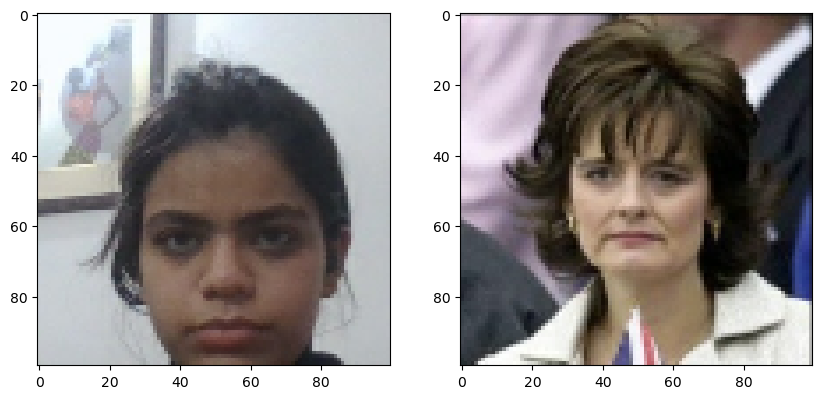

In [53]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [54]:
siamese_model.save('siamesemodel.h5')

C:\Users\suhan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
L1Dist
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [56]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 303ms/step


array([[4.1052411e-10],
       [3.9411262e-07],
       [9.9999726e-01],
       [1.0000000e+00]], dtype=float32)

In [57]:

os.listdir(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'verification_images'))

['848385c6-b079-11ee-8a30-f8a5c86ba23b - Copy.jpg',
 '8fce1d86-b079-11ee-bc6d-f8a5c86ba23b - Copy.jpg',
 '8fd9b1c7-b079-11ee-8fc2-f8a5c86ba23b - Copy.jpg',
 '8fe27cda-b079-11ee-881a-f8a5c86ba23b - Copy.jpg',
 '8ffe5405-b079-11ee-a142-f8a5c86ba23b - Copy.jpg',
 '910f10c3-b079-11ee-905a-f8a5c86ba23b - Copy.jpg',
 '91221b57-b079-11ee-8e45-f8a5c86ba23b - Copy.jpg',
 '912a507a-b079-11ee-9f3b-f8a5c86ba23b - Copy.jpg',
 '97cf41b8-b079-11ee-8dfc-f8a5c86ba23b - Copy.jpg',
 '97d8a637-b079-11ee-bca2-f8a5c86ba23b - Copy.jpg',
 '980773cb-b079-11ee-aa23-f8a5c86ba23b - Copy.jpg',
 '980d9225-b079-11ee-abb9-f8a5c86ba23b - Copy.jpg',
 '981e8db6-b079-11ee-9144-f8a5c86ba23b - Copy.jpg',
 '98601d2f-b079-11ee-a668-f8a5c86ba23b - Copy.jpg',
 '9897954b-b079-11ee-95ae-f8a5c86ba23b - Copy.jpg',
 '9c00c764-b079-11ee-8af8-f8a5c86ba23b - Copy.jpg',
 'a5c8eef8-b079-11ee-b116-f8a5c86ba23b - Copy.jpg',
 'a6619452-b079-11ee-b04d-f8a5c86ba23b - Copy.jpg',
 'a8c9ec33-b079-11ee-a32e-f8a5c86ba23b - Copy.jpg',
 'a91bcb14-b

In [58]:
os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'input_image', 'input_image.jpg')

'C:\\Users\\suhan\\OneDrive\\Desktop\\deep_fake\\project\\application_data\\input_image\\input_image.jpg'

In [59]:
for image in os.listdir(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'verification_images')):
    validation_img = os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'verification_images', image)
    print(validation_img)

C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\848385c6-b079-11ee-8a30-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\8fce1d86-b079-11ee-bc6d-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\8fd9b1c7-b079-11ee-8fc2-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\8fe27cda-b079-11ee-881a-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\8ffe5405-b079-11ee-a142-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\910f10c3-b079-11ee-905a-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data\verification_images\91221b57-b079-11ee-8e45-f8a5c86ba23b - Copy.jpg
C:\Users\suhan\OneDrive\Desktop\deep_fake\project\appli

In [60]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'verification_images')):
        input_img = preprocess(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join(r'C:\Users\suhan\OneDrive\Desktop\deep_fake\project\application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 52ms/step
True
1/1 [==============================] - 0s 61ms/step
True
1/1 [==============================] - 0s 51ms/step
False
